# Data Science 4 Covid19

Data import and preprocessing

In [115]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install geopandas & descartes, base env
import geopandas
%matplotlib inline
import os

ROOT_FOLDER = "C:\\Users\\liamo\\Documents\\BIOINF\\SIB\\tp\\trab"
CV19_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data.csv")
CV19_CONC_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos.csv")
CV19_CONC_RECENT_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos_14dias.csv")
# CV19_INCID_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos_incidencia.csv")

POPGETARIO_CONC_PATH = os.path.join(ROOT_FOLDER,"popres31dez19_porgetario.xlsx")
GETARIO_GENDER_PATH = os.path.join(ROOT_FOLDER,"getario_gender_sim.csv")

TEMP_PRECIP_PATH = os.path.join(ROOT_FOLDER,"ipma_clean.csv")
MORE_DATA_PATH = os.path.join(ROOT_FOLDER,"more_pordata.csv")
PATH_MAP = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","extra","mapas","portugal_continental","portugal_continental.shp")
CONC_PATH_MAP = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","extra","mapas","concelhos","concelhos.shp")

In [117]:
conc_data = pd.read_csv(CV19_CONC_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0]) 
conc_rec_data = pd.read_csv(CV19_CONC_RECENT_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0]) 
# conc_incid = pd.read_csv(CV19_INCID_PATH,parse_dates=True,infer_datetime_format=True,index_col=[0])
getario = pd.read_excel(POPGETARIO_CONC_PATH,usecols=list(range(21)),nrows=353,skiprows=list(range(10)),header=0)
gegender = pd.read_csv(GETARIO_GENDER_PATH,header=[0,1],index_col=[0])
data = pd.read_csv(CV19_PATH,header=0,parse_dates=True,infer_datetime_format=True,index_col=[0])
temp_precip = pd.read_csv(TEMP_PRECIP_PATH,header=[0,1],index_col=[0],parse_dates=True,infer_datetime_format=True) 
more_pordata = pd.read_csv(MORE_DATA_PATH,header=[0,1],index_col=[0])

rep_dict = {"Ç":"C","Â":"A","Ã":"A","Á":"A","À":"A","É":"E","Ê":"E","Í":"I","Ó":"O","Ô":"O","Ú":"U"," ":"-"}
# fix header and upper case values
getario.rename(columns = {'Unnamed: 0':'Âmbito Geográfico','Unnamed: 1':'Concelho'}, inplace = True)
getario['Concelho'] = getario['Concelho'].str.upper()
getario['Concelho'].replace(rep_dict,regex=True,inplace=True)
getario = getario.drop([0],axis=0)
conc_get = getario[getario["Âmbito Geográfico"]=="Município"].drop(["Âmbito Geográfico"],axis=1)

temp_precip.rename(columns={c[1]: c[1].upper() for c in temp_precip.columns.values},inplace = True,level=1)

names = list(conc_data.columns.values)
tr_dict = {}
for n in range(len(names)): tr_dict[names[n]] = "".join([rep_dict.get(r, r) for r in names[n].upper()]) 
conc_data.rename(columns=tr_dict,inplace = True)
conc_rec_data.rename(columns=tr_dict,inplace = True)
# conc_incid.rename(columns=tr_dict,inplace = True)

#add latest weekly dates
conc_rec_data = conc_rec_data.loc[conc_rec_data.index > conc_data.tail(1).index.item(),:]
conc_data = pd.concat((conc_data,conc_rec_data),axis=0)
conc_data.index.rename("data",inplace=True)
del conc_rec_data

#change age group intervals to match covid data
conc_get["0_9"] = conc_get['0-04']+conc_get["05-09"]
conc_get["10_19"] = conc_get['10-14']+conc_get['15-19']
conc_get["20_29"] = conc_get['20-24']+conc_get['25-29']
conc_get["30_39"] = conc_get['30-34']+conc_get['35-39']
conc_get["40_49"] = conc_get['40-44']+conc_get['45-49']
conc_get["50_59"] = conc_get['50-54']+conc_get['55-59']
conc_get["60_69"] = conc_get['60-64']+conc_get['65-69']
conc_get["70_79"] = conc_get['70-74']+conc_get['75-79']
# conc_get["70_plus"] = conc_get['70-74']+conc_get['75-79']+conc_get['80-84']+conc_get['85 ou mais']
conc_get["80_plus"] = conc_get['80-84']+conc_get['85 ou mais']
conc_get = conc_get.drop(['0-04', '05-09', '10-14', '15-19', '20-24','25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
                          '55-59', '60-64','65-69', '70-74', '75-79', '80-84', '85 ou mais'],axis=1)
#PROBLEMA: DADOS DE 2011, DADOS POR GETARIO E SEXO SO VAO ATE "75 OU MAIS" -> ver Pordata_process

# fix negative incidence values
# conc_incid = conc_incid.abs()

The "conc_data" and "data" dataframes contain covid19 data, with "conc_data" focusing on daily/weekly confirmed cases in smaller country subdivisions ("concelhos") and "data" having more information, such as (accumulated) cases per age, hospital patients and deaths, and a country-wide scope. The "conc_get" dataframe contains the population's age group distribution per area subdivision and total population, which will be used to normalize cases by area. The "temp_precip" dataframe contains three daily metereological variables, namely (maximum and minimum) temperature and precipitation. <p>Finally, the last dataframe "more_pordata" contains the various socio-economic variables, by area subdivision, obtained from the PORDATA portal: doctors and farmacists / population ratio, number of hospitals, schools, universities and guests in hotels (and similar establishments), average monthly salary, purchasing power ratio,  and voting abstention rate.<p>FALTA EXPLICAR A SIMULACAO DOS DADOS POR GENERO COM BASE EM POP POR GENERO (2011) E TOTAL (2019)

In [118]:
print("conc_data Shape:",conc_data.shape) #data x concelho == date x area
print("Total conc_data NA count:",conc_data.isna().sum().sum())
print("Date range:",conc_data.index[0],"-",conc_data.index[-1],"\n")

print("conc_get Shape:",conc_get.shape) #concelho x idade == area x age
print("conc_get attributes:",conc_get.columns.values)
print("Total conc_get NA count:",conc_get.isna().sum().sum(),"\n")
      
print("data Shape:",data.shape) #data x variavel == date x variable
print("Date range:",data.index[0],"-",data.index[-1])
print("data attribute summary:",set([x.split("_")[0] for x in data.columns.values]))
print("Total data NA count:",data.isna().sum().sum(),"\n")

# print("conc_incid Shape:",conc_incid.shape) #data x variavel == date x variable
# print("Date range:",conc_incid.index[0],"-",conc_incid.index[-1])
# print("Total conc_incid NA count:",conc_incid.isna().sum().sum(),"\n")

print("temp_precip Shape:",temp_precip.shape) #data x concelho == date x area
print("Date range:",temp_precip.index[0],"-",temp_precip.index[-1])
print("temp_precip attribute summary:",set(temp_precip.columns.get_level_values(0)))
print("Total temp_precip NA count:",temp_precip.isna().sum().sum(),"\n")

#  total count (#) or normalize (# per 100k)???
att_sum = {'MedFarm': 'ratio', 'Hospitais': '#', 'Ensino': '# ',"Universidades": "# ",
           'GanhoMes': '€', 'PoderCompra': 'ratio %', 'Hospedes': '#', 'Abstencao': '%'}
print("more_pordata Shape:",more_pordata.shape) #concelho x varivel == area x variable
print("more_pordata attribute summary:",att_sum)
print("Total more_pordata NA count:",more_pordata.isna().sum().sum())

conc_data Shape: (127, 308)
Total conc_data NA count: 10868
Date range: 2020-03-24 00:00:00 - 2020-12-09 00:00:00 

conc_get Shape: (307, 11)
conc_get attributes: ['Concelho' 'Total' '0_9' '10_19' '20_29' '30_39' '40_49' '50_59' '60_69'
 '70_79' '80_plus']
Total conc_get NA count: 0 

data Shape: (293, 88)
Date range: 2020-02-26 00:00:00 - 2020-12-14 00:00:00
data attribute summary: {'lab', 'data', 'suspeitos', 'cadeias', 'confirmados', 'recuperados', 'internados', 'sintomas', 'ativos', 'vigilancia', 'n', 'obitos', 'transmissao'}
Total data NA count: 5593 

temp_precip Shape: (85, 831)
Date range: 2020-09-04 00:00:00 - 2020-12-01 00:00:00
temp_precip attribute summary: {'Precipitation', 'MinTemp', 'MaxTemp'}
Total temp_precip NA count: 0 

more_pordata Shape: (307, 20)
more_pordata attribute summary: {'MedFarm': 'ratio', 'Hospitais': '#', 'Ensino': '# ', 'Universidades': '# ', 'GanhoMes': '€', 'PoderCompra': 'ratio %', 'Hospedes': '#', 'Abstencao': '%'}
Total more_pordata NA count: 0


FILTRAR DATAS MAIS ANTIGAS? AS Q TÊM MAIS NAS. FILTRAR CERTOS CONCELHOS? 

In [119]:
print("conc_data NA count by place:\n",conc_data.isna().sum().describe(),"\n") #por concelho
print("conc_data NA count by date:\n",conc_data.apply(pd.isna).sum(axis=1).describe(),"\n") #por data
# print("conc_data Dates < 75% NAs",conc_data.loc[conc_data.apply(pd.isna).sum(axis=1)<0.75*conc_data.shape[0],:].shape)
# print("Places < 25% NAs",conc_data.loc[:,conc_data.isna().sum()<0.25*conc_data.shape[1]].shape)
# print("data NA count by date:\n",data.apply(pd.isna).sum(axis=1).describe(),"\n") #por data

conc_data NA count by place:
 count    308.000000
mean      35.285714
std       45.154922
min        0.000000
25%        2.000000
50%       10.500000
75%       76.250000
max      122.000000
dtype: float64 

conc_data NA count by date:
 count    127.000000
mean      85.574803
std       43.912163
min        0.000000
25%       64.000000
50%       84.000000
75%       90.000000
max      242.000000
dtype: float64 



In [120]:
# remove/replace NAs (naive)
conc_data.fillna(0, inplace=True)
data.fillna(0, inplace=True)

#area name mismatch
print(set(conc_data.columns.values).difference(set(more_pordata.index)))
print(set(conc_data.columns.values).difference(set(conc_get["Concelho"])))
get_data_diff = set(conc_get["Concelho"]).difference(set(conc_data.columns.values))
print(get_data_diff)
conc_data = conc_data.filter(conc_get["Concelho"],axis=1)
conc_get = conc_get[~conc_get["Concelho"].isin(get_data_diff)]
more_pordata = more_pordata[~more_pordata.index.isin(get_data_diff)]
# conc_incid = conc_incid.filter(conc_get["Concelho"],axis=1)
print(conc_data.shape,conc_get.shape,more_pordata.shape) #,conc_incid.shape

# temp_precip has more missing
print("temp_precip missing areas:",len(set(conc_data.columns.values).difference(set(temp_precip.columns.get_level_values(1)))))

{'CALHETA', 'PORTO-SANTO', 'LAGOA-(FARO)', 'CALHETA-(ACORES)'}
{'CALHETA', 'PORTO-SANTO', 'LAGOA-(FARO)', 'CALHETA-(ACORES)'}
{'LAGOA-[R.A.A.]', 'CALHETA-[R.A.A.]', 'CALHETA-[R.A.M.]'}
(127, 304) (304, 11) (304, 20)
temp_precip missing areas: 27


In [121]:
#combine the 2 dfs
conc_pop = conc_data.reset_index().melt(id_vars=['data'], var_name='Concelho', value_name='Casos')
conc_pop = conc_pop.merge(conc_get[['Concelho', 'Total']], how='left', left_on='Concelho', right_on='Concelho')

#normalize by population, per 100k people
conc_pop['Racio'] = round(conc_pop['Casos'] * 100*1000 / conc_pop['Total'], 1)
conc_pop = conc_pop.pivot_table(values='Racio', index='data', columns='Concelho')
print(conc_pop.iloc[-5:,:5]) #tail but less columns

Concelho    ABRANTES  AGUEDA  AGUIAR-DA-BEIRA  ALANDROAL  ALBERGARIA-A-VELHA
data                                                                        
2020-11-11     404.2   447.1            172.0       80.1               451.5
2020-11-20     577.9   592.5            236.5      200.3               579.9
2020-11-26     418.4   698.9            236.5      540.9               691.7
2020-12-03     222.0   655.5            644.9      601.0               691.7
2020-12-09     196.4   612.0            709.4      360.6               650.3


Exploratory Graphs

Text(0.5, 0.98, 'Acumulated Confirmed cases and Deaths in Portugal')

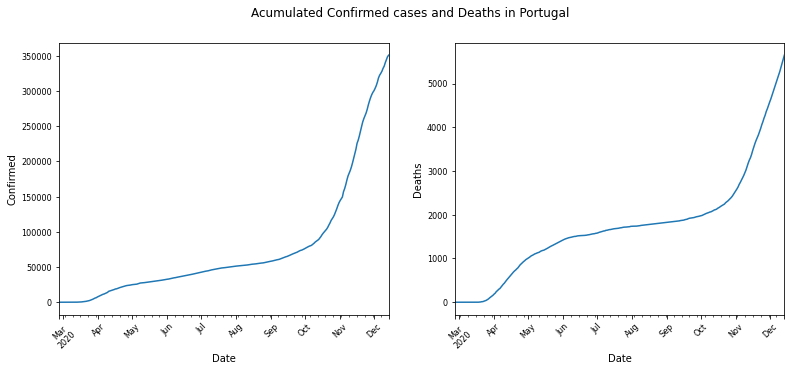

In [122]:
fig, ax = plt.subplots(1,2,figsize = (13,5))
data.plot(use_index=True,y=["confirmados"],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Confirmed",legend=False, ax=ax[0])
data.plot(use_index=True,y=["obitos"],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Deaths",ax=ax[1],legend=False)
fig.suptitle('Acumulated Confirmed cases and Deaths in Portugal', fontsize=12)

Fig 1 - Acumulated confirmed cases and deaths in Portugal. The second wave appears to start around September.

<AxesSubplot:xlabel='Date', ylabel='Confirmed per 100k habitants'>

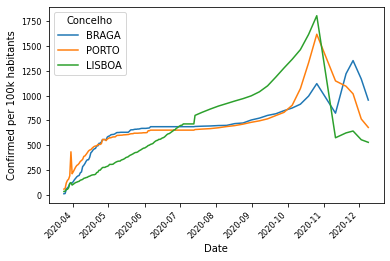

In [123]:
conc_pop.plot(use_index=True,y=["BRAGA","PORTO","LISBOA"],rot=45,fontsize=8,xlabel="Date", ylabel="Confirmed per 100k habitants")

Fig 2 - Confirmed cases per 100k habitants in three major portuguese cities, namely Braga, Porto and Lisbon. While Braga and Porto had an initially higher number of cases, Lisbon did not reach the same plateau and quicky segwayed into the second wave. However, after November the city has the least cases per 100k habitants out of the three.

<AxesSubplot:title={'center':'Symptoms'}>

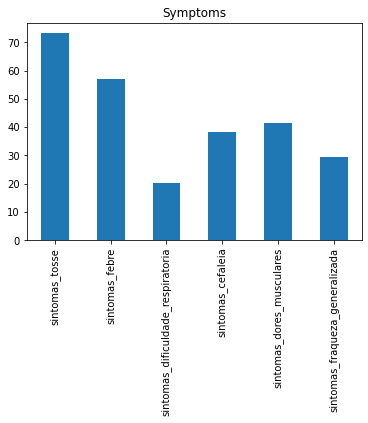

In [124]:
sintomas = [x for x in data.columns if "sintomas" in x]
# data.loc[:,sintomas].sum()
data.loc[:,sintomas].sum().plot(kind="bar",use_index=True,y=sintomas,title="Symptoms")

Fig ? - Reported symptoms. From left to right, the symptoms are coughing, fever, respiratory problems, headaches, muscle pain and generalized weakness. Coughing, followed by fever, are the most common symptoms. manter?

In [125]:
def plotbyage(variable,mfcols):
    male = data.iloc[:,mfcols[0]]
    male.insert(len(male.columns),"70_plus",male.loc[:,variable+"_70_79_m"]+male.loc[:,variable+"_80_plus_m"])
    male.drop([variable+"_70_79_m",variable+"_80_plus_m"],axis=1,inplace=True)

    fem = data.iloc[:,mfcols[1]]
    fem.insert(len(fem.columns),"70_plus",fem.loc[:,variable+"_70_79_f"]+fem.loc[:,variable+"_80_plus_f"])
    fem.drop([variable+"_70_79_f",variable+"_80_plus_f"],axis=1,inplace=True)
    labels = []
    for col in male.columns:
        if "plus" not in col: 
            col2 = "_".join(col.split("_")[1:3])
            colf = col.replace("_m","_f")
        else:
            col2 = col
            colf = col
        labels.append(col2)
        male.loc[:,col] = (male.loc[:,col]*100*100 / gegender.loc[:,("M",col2)].sum()).round(1)
        fem.loc[:,colf] = (fem.loc[:,colf]*100*100 / gegender.loc[:,("F",col2)].sum()).round(1)
    return (male,fem,labels)

conf_m,conf_f,labels = plotbyage("confirmados",(list(range(22,21+18,2)),list(range(21,21+18,2))))
death_m,death_f,labels = plotbyage("obitos",(list(range(64,63+18,2)),list(range(63,62+18,2))))

C:\Users\liamo\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\liamo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


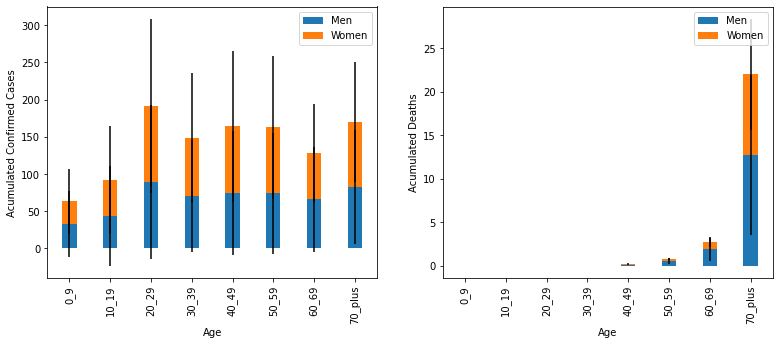

In [126]:
conf_m_means = conf_m.mean() 
conf_f_means = conf_f.mean()
conf_m_std = conf_m.std()
conf_f_std = conf_f.std()

death_m_means = death_m.mean() 
death_f_means = death_f.mean()
death_m_std = death_m.std()
death_f_std = death_f.std()
width = 0.35       

# fig, ax = plt.subplots()
fig, ax = plt.subplots(1,2,figsize = (13,5))
ax[0].set_xticks(list(range(len(labels))))
ax[0].set_xticklabels(labels, rotation='vertical')
ax[0].bar(labels, conf_m_means, width, yerr=conf_m_std, label='Men')
ax[0].bar(labels, conf_f_means, width, yerr=conf_f_std, bottom=conf_m_means, label='Women')
ax[0].set_ylabel('Acumulated Confirmed Cases')
ax[0].set_xlabel('Age')
# ax[0].set_title('Average Cases by Age and Gender')
ax[0].legend()

ax[1].set_xticks(list(range(len(labels))))
ax[1].set_xticklabels(labels, rotation='vertical')
ax[1].bar(labels, death_m_means, width, yerr=death_m_std, label='Men')
ax[1].bar(labels, death_f_means, width, yerr=death_f_std, bottom=death_m_means, label='Women')
ax[1].set_ylabel('Acumulated Deaths')
ax[1].set_xlabel('Age')
# ax[1].set_title('Average Deaths by Age and Gender')
ax[1].legend()
plt.show()
fig.suptitle('Average Confirmed cases and Deaths by Gender', fontsize=12)

# del conf_m_means,conf_f_means,death_m_means,death_f_means
del death_m_std,death_f_std,conf_m_std,conf_f_std,labels

Fig 3 - Average accumulated confirmed cases and deaths in Portugal (normalized) by age and gender. Cases seem to be more prevalent in the 20_29 and 70_plus age groups, with deaths only in age groups 40_49 and above, with most deaths concentrated on the 70_plus group.

Text(0.5, 0.98, 'Braga')

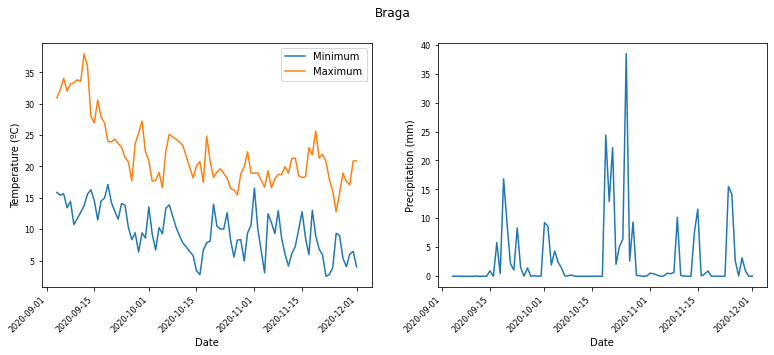

In [127]:
fig, ax = plt.subplots(1,2,figsize = (13,5))
temp_precip.plot(use_index=True,y=[("MinTemp", "BRAGA"),("MaxTemp", "BRAGA")],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Temperature (ºC)",legend=["Mínima","Máxima"], ax=ax[0])
temp_precip.plot(use_index=True,y=[("Precipitation", "BRAGA")],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Precipitation (mm)",ax=ax[1],legend=False)
ax[0].legend(["Minimum", "Maximum"])
fig.suptitle('Braga', fontsize=12)

Fig 4 - Daily temperature (in Celsius) and precipitation (mm) in the city of Braga over time.

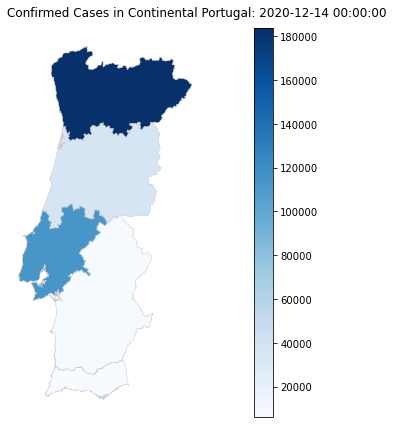

In [128]:
pt_map = geopandas.read_file(PATH_MAP)
df_most_recent_date = data.tail(1)
confirmed_col = {
    "Alentejo": df_most_recent_date["confirmados_arsalentejo"].item(),
    "Algarve": df_most_recent_date["confirmados_arsalgarve"].item(),
    "Centro": df_most_recent_date["confirmados_arscentro"].item(),
    "Norte": df_most_recent_date["confirmados_arsnorte"].item(), 
    "RLVT": df_most_recent_date["confirmados_arslvt"].item()
}
# df_most_recent_date.reset_index()["data"]
pt_map["confirmados"] = pt_map["CCDR"].map(confirmed_col)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(f"Confirmed Cases in Continental Portugal: {df_most_recent_date.reset_index()['data'].item()}", loc="left", pad=12.0)
ax.axis('off')
pt_map.plot(column="confirmados",cmap='Blues',ax=ax,legend=True,linewidth=0.5,edgecolor='0.8')
fig.tight_layout()
# plt.savefig('map.png', dpi=300, bbox_inches='tight')
plt.show()
del pt_map,df_most_recent_date,confirmed_col

Fig 5 - Most recent cases in Portugal available, by general area. The North of the country appears to have a greater number of cases. supérfluo??

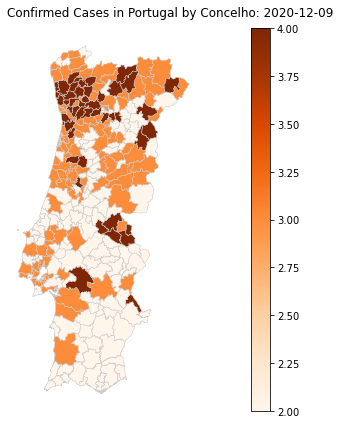

In [129]:
conc_pt_map = geopandas.read_file(CONC_PATH_MAP)
# conc_pt_map.columns.values
conc_pt_map.rename(columns={"NAME_2":"Concelho"},inplace=True)
conc_pt_map['Concelho'] = conc_pt_map['Concelho'].str.upper()
conc_pt_map['Concelho'].replace(rep_dict,regex=True,inplace=True)

conc_pt_map.loc[conc_pt_map['Concelho'] == 'PRAIA-DA-VITORIA',"Concelho"] = 'VILA-DA-PRAIA-DA-VITORIA'
conc_pt_map.loc[(conc_pt_map['Concelho'] == 'LAGOA') & (conc_pt_map['NAME_1'] == 'Faro'),"Concelho"] = 'LAGOA-(FARO)'
conc_pt_map.loc[(conc_pt_map['Concelho'] == 'CALHETA') & (conc_pt_map['NAME_1'] == 'Azores'),"Concelho"] = 'CALHETA-(AÇORES)'

# split into four categories
categories = conc_pop[-1:].melt(id_vars=[])
categories['category'] = 1 + np.ceil(categories.value.div(categories.value.median())) #!!!
categories['category'] = categories['category'].clip(0,4)

# merge map data with concelhos category
conc_pt_map = conc_pt_map.merge(categories[['Concelho', 'category']], how='right', left_on='Concelho', right_on='Concelho')
# Skip islands to show only continent
conc_pt_map = conc_pt_map[~conc_pt_map.NAME_1.isin(['Azores', 'Madeira'])]
# conc_pt_map

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(f"Confirmed Cases in Portugal by Concelho: {conc_pop.index.format()[-1]}", loc="left", pad=12.0) #mudar titulo
ax.axis('off')
conc_pt_map.plot(
    column='category',cmap='Oranges',ax=ax,legend=True,linewidth=0.5,edgecolor='0.8')
fig.tight_layout()
# plt.savefig('map.png', dpi=300, bbox_inches='tight')
plt.show()
del conc_pt_map

Fig 6 - Most recent confirmed cases in Portugal available, by smaller area subdivisions. The North of the country has the highest concentration of high case areas.

<h3>Statistical Analysis

As the ttest_ind p-value > 0.05, the null hypothesis is not rejected. In conclusion, there is no significant difference between confirmed cases in men and women. As expected since the deaths by age/gender were highly schewed towards older age groups, the data is not considered normal. As such, the nonparametric mannwhitney test was run instead and no significant difference in deaths by gender was found.<p>

In [130]:
from scipy import stats
# print("Average confirmed cases:\n",conf_f_means,"(F) vs (M)\n",conf_m_means,"\n")
print("Shapiro normality test - Assumed normal if p-value > 0.05")
print("conf_f_means:",stats.shapiro(conf_f_means))
print("conf_m_means:",stats.shapiro(conf_m_means))
print("death_f_means:",stats.shapiro(death_f_means))
print("death_m_means:",stats.shapiro(death_m_means),"\n")

print("Bartlett parametric equal variances test - assumed equal if p-value > 0.05")
print(stats.bartlett(conf_f_means,conf_m_means))
print("Independent samples t-test - Assumed equal means if p-value > 0.05")
print(stats.ttest_ind(conf_f_means,conf_m_means,equal_var=True),end="\n\n")
print("Mannwhitney nonparametric test - Assumed equal if p-value > 0.05")
print(stats.mannwhitneyu(death_f_means,death_m_means))

Shapiro normality test - Assumed normal if p-value > 0.05
conf_f_means: ShapiroResult(statistic=0.9115220308303833, pvalue=0.36490604281425476)
conf_m_means: ShapiroResult(statistic=0.9053751826286316, pvalue=0.32264208793640137)
death_f_means: ShapiroResult(statistic=0.4739788770675659, pvalue=5.008597327105235e-06)
death_m_means: ShapiroResult(statistic=0.519397497177124, pvalue=1.7668249711277895e-05) 

Bartlett parametric equal variances test - assumed equal if p-value > 0.05
BartlettResult(statistic=0.3410217597834124, pvalue=0.5592400357651515)
Independent samples t-test - Assumed equal means if p-value > 0.05
Ttest_indResult(statistic=0.6527296758197008, pvalue=0.5245047750644065)

Mannwhitney nonparametric test - Assumed equal if p-value > 0.05
MannwhitneyuResult(statistic=29.5, pvalue=0.4146242295914731)


The covid19 data by area ("conc_data") has mixed data, switching from daily cases to weekly. To ensure a balanced dataset, daily dates were converted to weekly. The weekly dataset was then divided into first and second waves.

In [131]:
#diários até 13-07-2020 depois semanal - 6-13/7??? !!!15-12-2020!!!
#convert daily cases to weekly
#BOXPLOTS? OUTLIERS? CORTAR DATAS COM MUITOS NAS?
tofix = conc_data.loc[conc_data.index < "2020-07-14",:] 
tofix = tofix.loc[tofix.index!="2020-07-13",:] 
weekly = []
weekly_dates = []
for i in range(0,len(tofix.index)-6,7): 
    weekly_dates.append(tofix.index[i])
    weekly.append(tofix.loc[tofix.index[i:i+7],:].sum())
fixed = pd.DataFrame(weekly,index=weekly_dates)
conc_data_wee = pd.concat((fixed,conc_data.loc[conc_data.index >= "2020-07-14",:]),axis=0)
conc_data_wee.index.rename("data",inplace=True)

#normalize by population, per 100k people
conc_pop_wee = conc_data_wee.reset_index().melt(id_vars=['data'], var_name='Concelho', value_name='Casos')
conc_pop_wee = conc_pop_wee.merge(conc_get[['Concelho', 'Total']], how='left', left_on='Concelho', right_on='Concelho')
conc_pop_wee['Racio'] = round(conc_pop_wee['Casos'] * 100*1000 / conc_pop_wee['Total'], 1)
conc_pop_wee = conc_pop_wee.pivot_table(values='Racio', index='data', columns='Concelho')

conc_first_wave = conc_pop_wee[conc_pop_wee.index < "2020-08-01"] #"2020-07-01"
conc_sec_wave = conc_pop_wee[conc_pop_wee.index >= "2020-08-01"] 

conc_first_wave = conc_first_wave.loc[:,conc_first_wave.sum()!=0]
diff = set(conc_sec_wave).difference(set(conc_first_wave))
conc_sec_wave = conc_sec_wave.loc[:,~conc_sec_wave.columns.isin(diff)]

print("First wave shape:",conc_first_wave.shape) 
print(conc_first_wave.iloc[:5,:5],end="\n\n")
print("Second wave shape:",conc_sec_wave.shape)
print(conc_sec_wave.iloc[:5,:5])
del tofix,weekly,weekly_dates,fixed,conc_data_wee

First wave shape: (18, 255)
Concelho    ABRANTES  AGUEDA  ALANDROAL  ALBERGARIA-A-VELHA  ALBUFEIRA
data                                                                  
2020-03-24      19.9   156.3        0.0               700.0      276.9
2020-03-31       0.0   321.2        0.0              1284.0      616.5
2020-04-07      62.6   453.6        0.0              1524.2      852.4
2020-04-14     116.7   590.3        0.0              1631.9     1035.4
2020-04-21     145.2   635.9        0.0              1839.0     1165.5

Second wave shape: (18, 255)
Concelho    ABRANTES  AGUEDA  ALANDROAL  ALBERGARIA-A-VELHA  ALBUFEIRA
data                                                                  
2020-08-03      93.9   225.7       60.1               381.0      370.8
2020-08-10     102.5   232.2       60.1               397.6      378.1
2020-08-17     105.3   238.7       60.1               401.8      394.9
2020-08-24     111.0   256.1       60.1               401.8      416.6
2020-08-31     116.

It was found that over half of the areas had a significant difference between first and second waves.

In [132]:
# from scipy import stats
# print("Shapiro normality test - Assumed normal if p-value > 0.05")
# print("Significant normality count (more_pordata):",(more_pordata.apply(stats.shapiro,axis=0).iloc[1,:] > 0.05).sum(),"\n") #
# print("Significant normality count (conc_pop):",(conc_pop.loc[:,conc_pop.sum()!=0].apply(stats.shapiro,axis=0).iloc[1,:]>0.05).sum())

print("Mannwhitney nonparametric test - Assumed equal if p-value > 0.05") #conc_pop.loc[:,conc_pop.sum()!=0].columns
dic = {x:stats.mannwhitneyu(conc_first_wave[x],conc_sec_wave[x]) for x in conc_first_wave.columns}
dic_df = pd.DataFrame()
dic_df = dic_df.from_dict(dic)

print("Significant difference % (p-value <= 0.05):",(dic_df.iloc[1,:]<=0.05).sum()*100/dic_df.shape[1])
signif = dic_df.loc[:,dic_df.iloc[1,:]<=0.05].columns
# print("first_wave/sec_wave significant areas:",conc_first_wave.loc[:,signif].shape[1])
# del signif

Mannwhitney nonparametric test - Assumed equal if p-value > 0.05
Significant difference % (p-value <= 0.05): 65.49019607843137


After converting the general covid19 dataset ("data") into weekly dates, it was found that symptoms reported and number of deaths were very highly correlated, but with a negative correlation. When excluding NAs (previously converted to 0s), the correlation is almost perfect.

In [133]:
weekly = []
weekly_dates = []
for i in range(list(data.index).index(conc_pop_wee.index[0]),len(data.index)-6,7): 
    weekly_dates.append(data.index[i])
    weekly.append(data.loc[data.index[i:i+7],:].sum())
data_wee = pd.DataFrame(weekly,index=weekly_dates)
data_wee = data_wee.loc[:,data_wee.columns!="data_dados"] 
print("Weekly data:",data_wee.index[:5],"...",end="\n\n")

# data_first_wave = data_wee[data_wee.index < "2020-08-01"] #"2020-07-01"
# data_sec_wave = data_wee[data_wee.index >= "2020-08-01"] 
# print(data_first_wave.shape,data_sec_wave.shape)
del weekly, weekly_dates #,conc_pop_wee

#ESCALA SINTOMAS?? NAO E %?
#CORR ENTRE SINTOMAS E MORTES - NEGATIVA???
sintomas = [x for x in data.columns if "sintomas" in x]
data_sint = data_wee.loc[np.sum(data_wee.loc[:,sintomas]==0,axis=1)!=len(sintomas),sintomas]
# print(data_sint.shape)
print(data_wee.loc[:,["obitos"]+sintomas].corr().iloc[:,0],end="\n\n") #-0.7 com "NAs"
print(data_wee.loc[np.sum(data_wee.loc[:,sintomas]==0,axis=1)!=len(sintomas),["obitos"]+sintomas].corr().iloc[:,0]) #-0.9+!

Weekly data: DatetimeIndex(['2020-03-24', '2020-03-31', '2020-04-07', '2020-04-14',
               '2020-04-21'],
              dtype='datetime64[ns]', freq=None) ...

obitos                               1.000000
sintomas_tosse                      -0.728553
sintomas_febre                      -0.728880
sintomas_dificuldade_respiratoria   -0.734624
sintomas_cefaleia                   -0.715960
sintomas_dores_musculares           -0.721135
sintomas_fraqueza_generalizada      -0.730207
Name: obitos, dtype: float64

obitos                               1.000000
sintomas_tosse                      -0.986048
sintomas_febre                      -0.966827
sintomas_dificuldade_respiratoria   -0.988203
sintomas_cefaleia                   -0.914273
sintomas_dores_musculares           -0.944147
sintomas_fraqueza_generalizada      -0.971104
Name: obitos, dtype: float64


With Christmas fast approaching, we attempted to predict the impact of major holidays on cases, using Easter. Before Easter, the average weekly increase in cases was under 50%. In the week after easter, however, cases saw a 70% jump. Testing the significance of this difference with a nonparamatric mannwhitney test confirmed this as very significant. While this is a very simplistic analysis, it is expected for cases to soar after Christmas as restrictions are lifted and people gather with their families, regardless.

In [134]:
#NORMLAIZAR DATA POR GRETARIOS E JUNTAR A CORR?
#PASCOA PARA PREVER NATAL/ANO NOVO?
antes_pascoa = conc_pop_wee[conc_pop_wee.index < "2020-04-01"]
antes_pascoa = antes_pascoa.loc[:,~(antes_pascoa==0).any()]
print("Average increase in weekly cases before Easter:",
    (antes_pascoa.iloc[0,:]/antes_pascoa.iloc[1,:]).mean()*100) #em media casos aumentaram 45% antes da pascoa 

pascoa = conc_pop_wee[(conc_pop_wee.index >= "2020-04-01") & (conc_pop_wee.index < "2020-04-21")]
pascoa = pascoa.loc[:,~(pascoa==0).any()] #pascoa.sum()!=0
# print(pascoa.iloc[:,:5])
print("Average increase in weekly cases in the week after Easter:",
      (pascoa.iloc[0,:]/pascoa.iloc[1,:]).mean()*100) #em media casos aumentaram 74% depois da semana da pascoa 
# print(set(antes_pascoa.columns).difference(set(pascoa.columns))) == 0

#testar significancia
print("Mannwhitney nonparametric test - Assumed equal if p-value > 0.05")
print(stats.mannwhitneyu(antes_pascoa.iloc[0,:]/antes_pascoa.iloc[1,:],pascoa.iloc[0,:]/pascoa.iloc[1,:]))

Average increase in weekly cases before Easter: 44.85372395384932
Average increase in weekly cases in the week after Easter: 73.56706563540364
Mannwhitney nonparametric test - Assumed equal if p-value > 0.05
MannwhitneyuResult(statistic=2787.0, pvalue=1.6260253700363447e-35)


Daily meteorological data (minimum & maximum temperature and precipitation) and the corresponding confirmed cases of that day have only a small positive correlation.

In [135]:
mintemp = temp_precip.loc['2020-10-26',"MinTemp"]
maxtemp = temp_precip.loc['2020-10-26',"MaxTemp"]
precip = temp_precip.loc['2020-10-26',"Precipitation"]
conc_pop2 = conc_data.tail(1).transpose().filter(mintemp.index,axis=0)
latest = pd.concat((mintemp,maxtemp,precip,conc_pop2),axis=1,keys=["MinTemp","MaxTemp","Precipitation","Cases"])
print(latest.corr().iloc[:,-1])

               data      
MinTemp        2020-10-26    0.133400
MaxTemp        2020-10-26    0.112727
Precipitation  2020-10-26    0.156494
Cases          2020-12-09    1.000000
Name: (Cases, 2020-12-09 00:00:00), dtype: float64


Text(0.5, 1.0, 'Correlation Matrix')

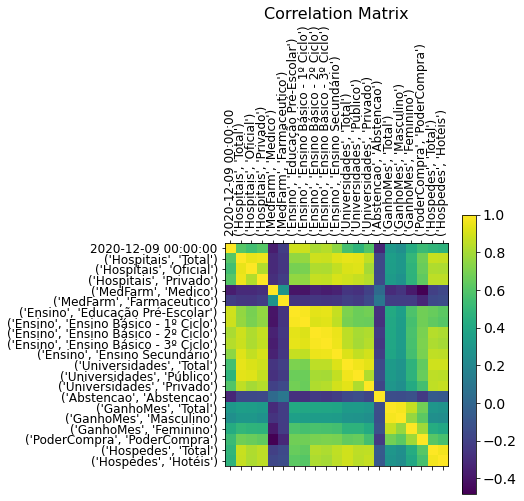

In [136]:
conc_pop2 = conc_data.tail(1).transpose().filter(more_pordata.index,axis=0)
latest = pd.concat((conc_pop2,more_pordata),axis=1) 

f = plt.figure(figsize=(5, 5))
plt.matshow(latest.corr(), fignum=f.number)
plt.xticks(range(latest.shape[1]), latest.columns.get_level_values(0), fontsize=12, rotation=90)
plt.yticks(range(latest.shape[1]), latest.columns.get_level_values(0), fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

Fig 7 - Correlation heatmap between socio-economic variables and latest number of confirmed cases by small are subdivision.

In [137]:
#classify latest date cases (normalized by population) into classes
cases_class = 1 + np.ceil(conc_pop2.div(conc_pop2.mean())) #conc_pop2.quantile(0.75)
cases_class = cases_class.clip(0,4)
latest2 = more_pordata.copy(deep=True)
for col in latest2.columns:
    temp = 1 + np.ceil(latest2[col].div(latest2[col].mean()))
    latest2[col] = temp.clip(0,4)
latest2 = pd.concat((cases_class,latest2),axis=1)
latest2.head()

,2020-12-09 00:00:00,"(Hospitais, Total)","(Hospitais, Oficial)","(Hospitais, Privado)","(MedFarm, Medico)","(MedFarm, Farmaceutico)","(Ensino, Educação Pré-Escolar)","(Ensino, Ensino Básico - 1º Ciclo)","(Ensino, Ensino Básico - 2º Ciclo)","(Ensino, Ensino Básico - 3º Ciclo)",...,"(Universidades, Total)","(Universidades, Público)","(Universidades, Privado)","(Abstencao, Abstencao)","(GanhoMes, Total)","(GanhoMes, Masculino)","(GanhoMes, Feminino)","(PoderCompra, PoderCompra)","(Hospedes, Total)","(Hospedes, Hotéis)"
Concelho,,,,,,,,,,,,,,,,,,,,,
ARCOS-DE-VALDEVEZ,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0
CAMINHA,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
MELGACO,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0
MONCAO,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0
PAREDES-DE-COURA,2.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0


In a previous analysis, the correlation between the covid data and the socio-economic variables is higher, for most variables, when the covid data is divided into classes. However, with the latest date (2020-12-09) the opposite is true, with minimal improvement.

In [138]:
corr = pd.concat((latest.corr().iloc[1:,0],latest2.corr().iloc[1:,0]),axis=1)
corr = pd.concat((corr,abs(corr.iloc[:,0])<abs(corr.iloc[:,1])),axis=1)
print("\t\t\t\tOriginal,Divided into classes,Improvement")
print(corr)

				Original,Divided into classes,Improvement
                                    2020-12-09  2020-12-09  2020-12-09
(Hospitais, Total)                    0.607630    0.605901       False
(Hospitais, Oficial)                  0.549556    0.560764        True
(Hospitais, Privado)                  0.610826    0.443289       False
(MedFarm, Medico)                    -0.361245   -0.345054       False
(MedFarm, Farmaceutico)              -0.211448   -0.145502       False
(Ensino, Educação Pré-Escolar)        0.895203    0.824508       False
(Ensino, Ensino Básico - 1º Ciclo)    0.887299    0.798303       False
(Ensino, Ensino Básico - 2º Ciclo)    0.812377    0.815024        True
(Ensino, Ensino Básico - 3º Ciclo)    0.833417    0.791511       False
(Ensino, Ensino Secundário)           0.745867    0.759672        True
(Universidades, Total)                0.557512    0.568485        True
(Universidades, Público)              0.484258    0.445290       False
(Universidades, Privado)       

In the mentioned previous analysis, even the latter had only a few variables with an absolute correlation of 0.3 or above. However, the most recent data has a high correlation with most variables.

In [147]:
# corr2 = corr.loc[corr.iloc[:,-1],:].iloc[:,1]
corr.loc[abs(corr.iloc[:,0])>=0.5].iloc[:,0]

(Hospitais, Total)                    0.607630
(Hospitais, Oficial)                  0.549556
(Hospitais, Privado)                  0.610826
(Ensino, Educação Pré-Escolar)        0.895203
(Ensino, Ensino Básico - 1º Ciclo)    0.887299
(Ensino, Ensino Básico - 2º Ciclo)    0.812377
(Ensino, Ensino Básico - 3º Ciclo)    0.833417
(Ensino, Ensino Secundário)           0.745867
(Universidades, Total)                0.557512
(Universidades, Privado)              0.597745
(PoderCompra, PoderCompra)            0.526137
Name: 2020-12-09 00:00:00, dtype: float64

<h3>Unsupervised multivariate analysis

In [148]:
#para cores labels / clusters etc?
nuts2_conc = pd.read_csv(os.path.join(ROOT_FOLDER,"wiki_nuts2_concelhos.csv"),header=0,usecols=["Nível II","Concelhos"])
nuts2_conc['Concelhos'] = nuts2_conc['Concelhos'].str.upper()
nuts2_conc['Concelhos'].replace(rep_dict,regex=True,inplace=True)
nuts2_conc['Nível II'] = nuts2_conc['Nível II'].str.upper()
nuts2_conc['Nível II'].replace(rep_dict,regex=True,inplace=True)

nuts2_conc = nuts2_conc.merge(conc_get[['Concelho']], how='right', left_on='Concelhos', right_on='Concelho')
nuts2_conc.fillna("OTHER",inplace=True) 
print(nuts2_conc["Nível II"].value_counts())

# label_colors = {'REGIAO-DO-CENTRO': 'r', 'REGIAO-DO-NORTE': 'g', 'ALENTEJO': 'b',"UNKNOWN":"c",
#                 "REGIAO-DE-LISBOA":"m","ALGARVE":"y"}

REGIAO-DO-CENTRO    97
REGIAO-DO-NORTE     81
ALENTEJO            56
OTHER               36
REGIAO-DE-LISBOA    18
ALGARVE             16
Name: Nível II, dtype: int64


In [150]:
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

lat_sc = preprocessing.scale(latest)

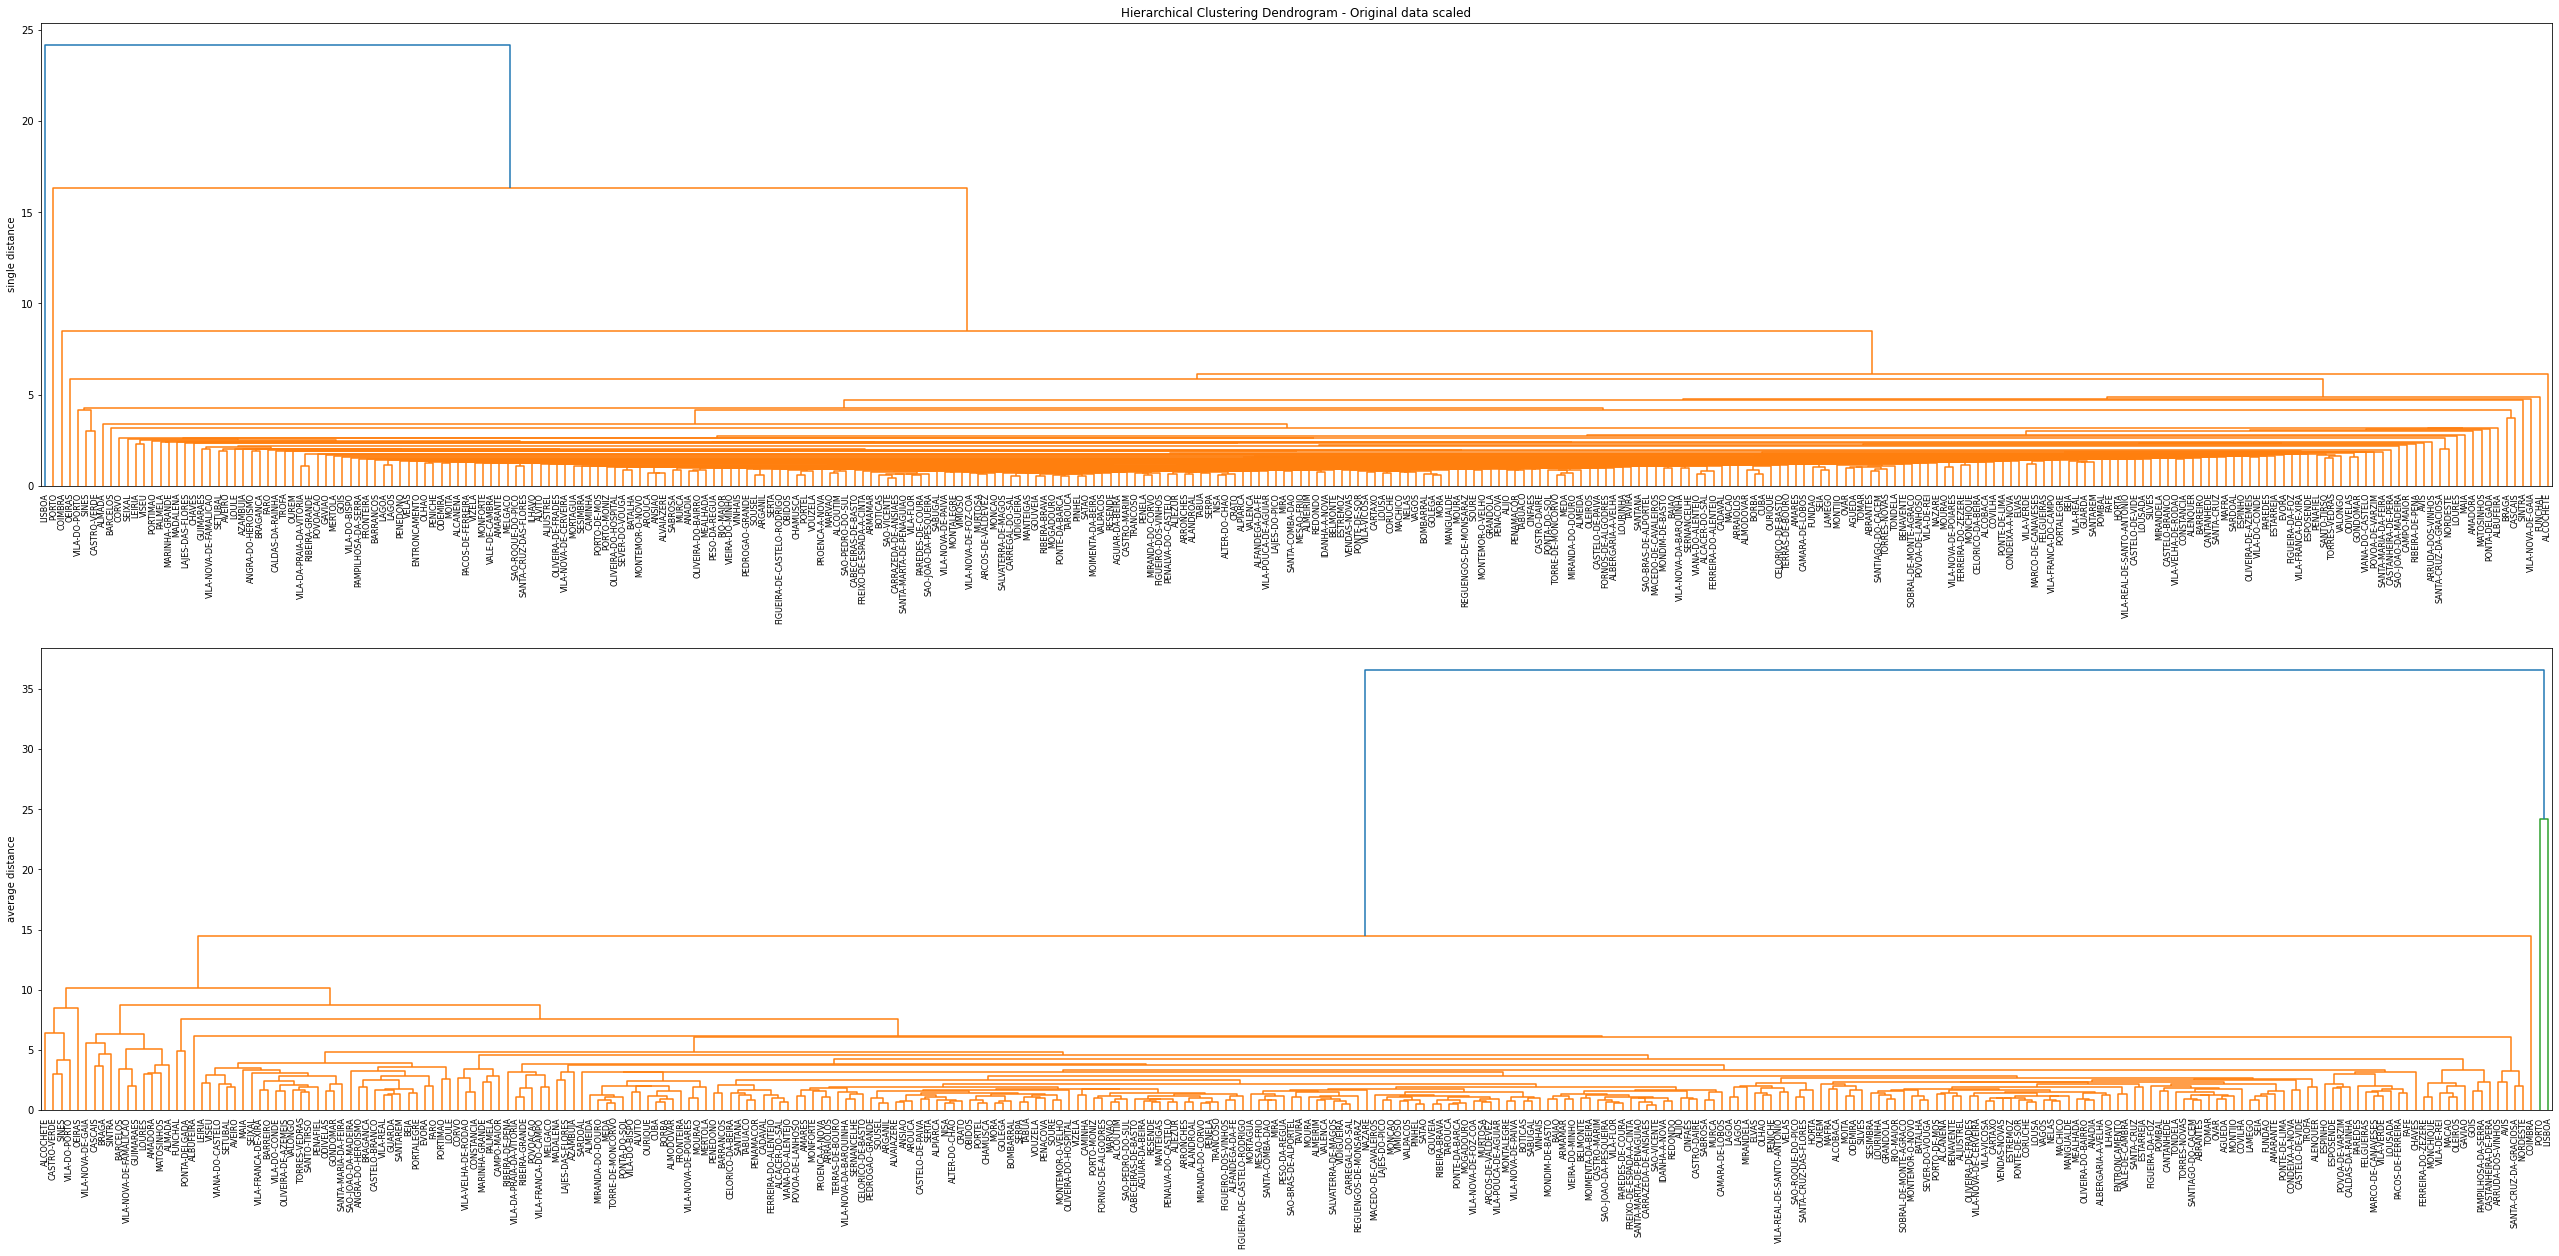

In [151]:
Z = linkage(lat_sc, method='single', metric='euclidean',optimal_ordering=True)
Zav = linkage(lat_sc, method='average', metric='euclidean',optimal_ordering=True)

# calculate full dendrogram
fig, ax = plt.subplots(2,1,figsize=(45, 20))
Z1 = dendrogram(Z, orientation='top', labels=list(latest.index),leaf_font_size=8,ax=ax[0])
Z2 = dendrogram(Zav, orientation='top', labels=list(latest.index),leaf_font_size=8,ax=ax[1]) 
ax[0].set_title('Hierarchical Clustering Dendrogram - Original data scaled')
ax[0].set_ylabel('single distance')
ax[1].set_ylabel('average distance')
plt.subplots_adjust(hspace=0.35)
plt.show()

Fig 8 - Hierarchical clustering dendrogram of the original scaled data comparing the single (Top) and average (Bottom) methods. Average method clustering appears to better discriminate clusters.

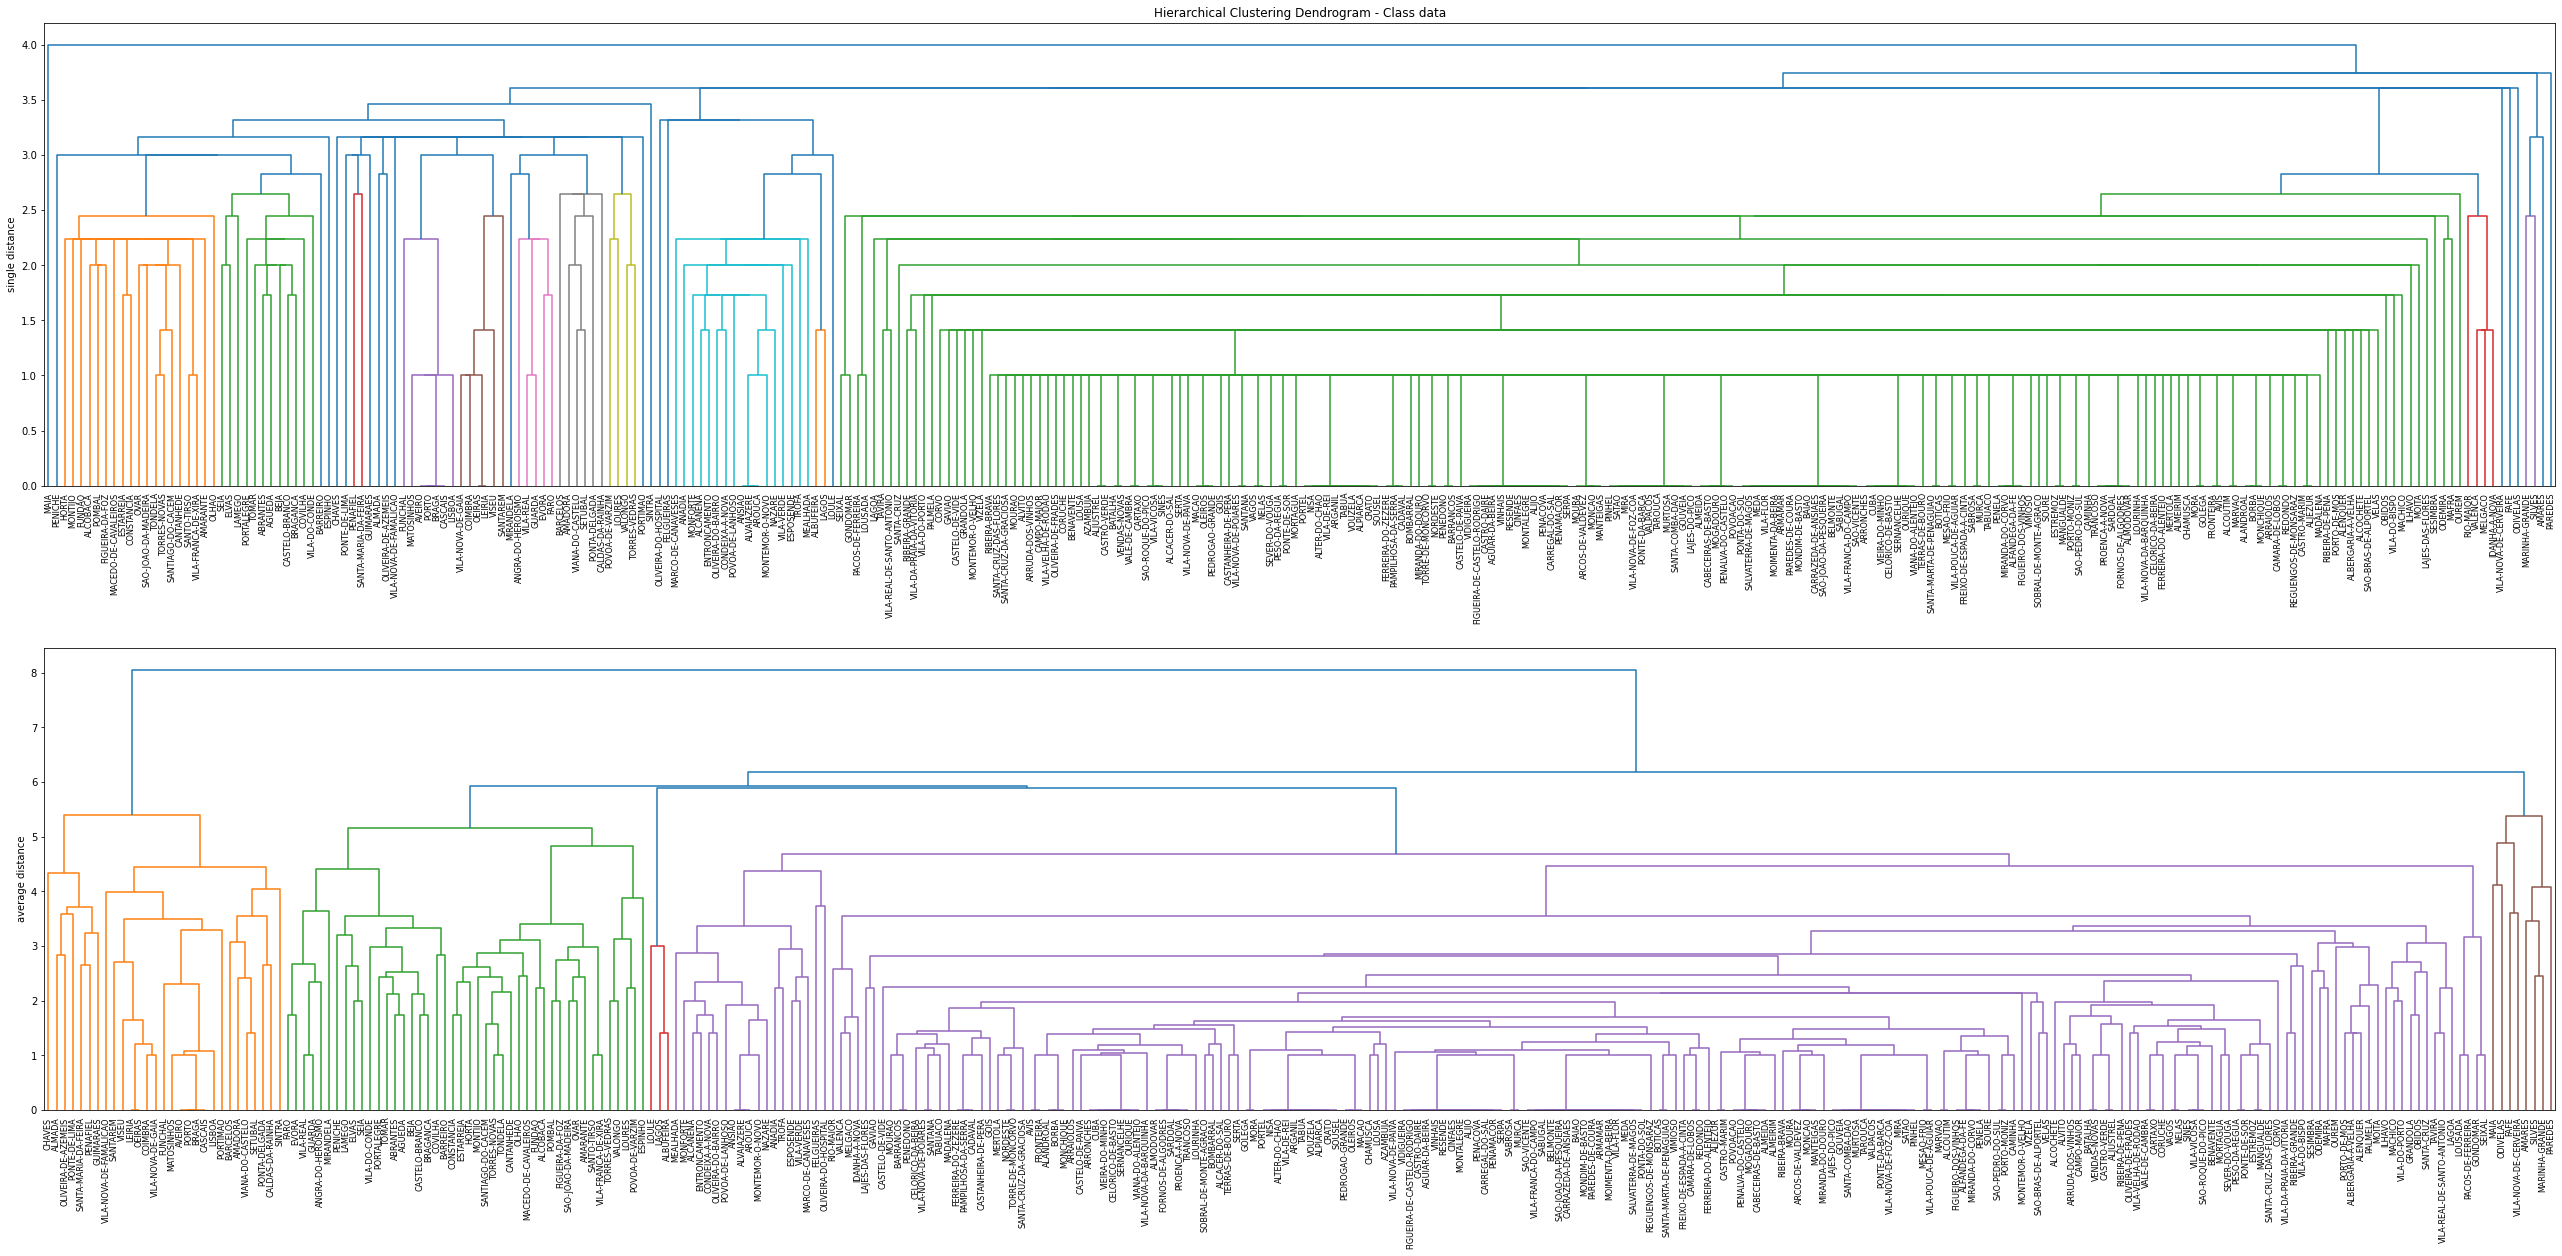

In [152]:
Z = linkage(latest2, method='single', metric='euclidean',optimal_ordering=True)
Zav = linkage(latest2, method='average', metric='euclidean',optimal_ordering=True)

# calculate full dendrogram
fig, ax = plt.subplots(2,1,figsize=(45, 20))
Z1 = dendrogram(Z, orientation='top', labels=list(latest2.index),leaf_font_size=8,ax=ax[0])
Z2 = dendrogram(Zav, orientation='top', labels=list(latest2.index),leaf_font_size=8,ax=ax[1]) # best?
ax[0].set_title('Hierarchical Clustering Dendrogram - Class data')
ax[0].set_ylabel('single distance')
ax[1].set_ylabel('average distance')
plt.subplots_adjust(hspace=0.35)
plt.show()

Fig 9 - Hierarchical clustering dendrogram of the data divided into classes comparing the single (Top) and average (Bottom) methods. As with the previous figure, the average linkage clustering performs better. In addition, the class data is even better organized in clusters.

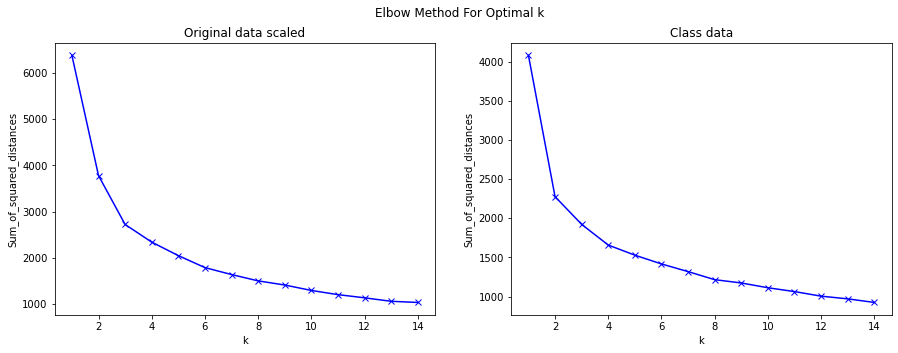

In [153]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
Sum_of_squared_distances2 = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(lat_sc)
    Sum_of_squared_distances.append(km.inertia_)
    
    km2 = KMeans(n_clusters=k)
    km2 = km2.fit(latest2)
    Sum_of_squared_distances2.append(km2.inertia_)

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].plot(K, Sum_of_squared_distances, 'bx-')
ax[1].plot(K, Sum_of_squared_distances2, 'bx-')
ax[0].set_xlabel('k')
ax[1].set_xlabel('k')
ax[0].set_ylabel('Sum_of_squared_distances')
ax[1].set_ylabel('Sum_of_squared_distances')
ax[0].set_title('Original data scaled')
ax[1].set_title('Class data')
fig.suptitle('Elbow Method For Optimal k')

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
plt.show()

Fig 10 - Elbow method for determining the ideal k parameter for kmeans. Left: Original data scaled. Right: data divided into classes.

In [154]:
k=4
np.random.seed(2) 
kmeans_data = KMeans(n_clusters=k, max_iter=1000)
kmeans_data.fit(latest2)
labels = kmeans_data.labels_
centroids = kmeans_data.cluster_centers_

# table = pd.crosstab(labels,nuts2_conc["Nível II"], rownames=['clusters']) #para k=6
# print(table,end="\n\n")
print(pd.DataFrame(labels).value_counts())

# for i in range(k): #???
#     ds = latest2.iloc[np.where(np.array(labels)==i)[0],:] #data_sc.iloc[np.where(labels==i),:]
#     plt.plot(ds[:,0],ds[:,1],'o')  
#     lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     plt.setp(lines,ms=10.0)   
#     plt.setp(lines,mew=2.0)    
# plt.show()

0    201
3     39
1     36
2     28
dtype: int64


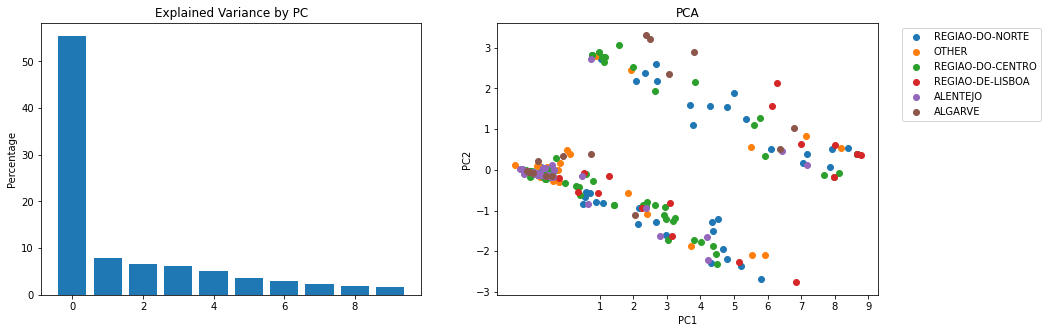

In [155]:
from sklearn.decomposition import PCA
pca_data = PCA(n_components=0.95) #n_iter=1000?
pca_data.fit(latest2)
x_reduced = pca_data.transform(latest2)

fig, ax = plt.subplots(1,2,figsize=(15, 5))
i95 = np.where(pca_data.explained_variance_ratio_.cumsum()*100 >= 95)[0][0]
ax[0].bar(range(i95), pca_data.explained_variance_ratio_[:i95]*100)
plt.xticks(range(i95), list(range(1,i95+1))) #['PC'+str(i) for i in range(1,i95+1)]
ax[0].set_title("Explained Variance by PC")
ax[0].set_ylabel("Percentage")

for nuts in nuts2_conc["Nível II"].unique():
    sp = nuts2_conc.index[nuts2_conc["Nível II"]==nuts]-1
    ax[1].plot(x_reduced[sp,0],x_reduced[sp,1], 'o' , label=nuts)
ax[1].set_title("PCA")
ax[1].legend(bbox_to_anchor=(1.05, 1), shadow=False) 
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')

plt.show()

Fig 11 - Principal component analysis (PCA) of the data divided into classes. Left: Percentage of variance explained per component up to the component reaching 95% explained variance. Right: PC1 and PC2 plotted. 

In [156]:
# from sklearn.manifold import TSNE
# tsne = TSNE() 
# points = tsne.fit_transform(data_sc)

# for nuts in nuts2_conc["Nível II"].unique():
#     sp = nuts2_conc.index[nuts2_conc["Nível II"]==nuts]-1
#     plt.plot(points[sp,0],points[sp,1], 'o' , label=nuts)
# plt.title("tSNE")
# plt.legend(bbox_to_anchor=(1.05, 1), shadow=False)
# plt.show()

<h3>Supervised Machine Learning?

## References
Dataset(s) COVID-19 PT (includes map files): https://github.com/dssg-pt/covid19pt-data<br>
Area code data (concelhos/distritos) (ipma data extraction): https://github.com/centraldedados/codigos_postais<br>
Meteorological data: http://api.ipma.pt/#services<br>
General area data (NUTS/concelho): https://pt.wikipedia.org/wiki/Lista_de_concelhos_por_NUTS,_distritos_e_ilhas<br>
Rest of data: https://www.pordata.pt/